# 自己符号化器で通信システム(AWGN通信路)をモデリングする

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### グローバル変数の設定

In [2]:
M = 32
K = 100
num_hidden_units = 10 
sigma = 0.1

0.1

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    r = zeros(M, K)
    for j in 1:K
        r[rand(1:M),j] = 1
    end
    return r
end

mini_batch (generic function with 1 method)

### 全結合層の定義

In [4]:
enc1 = Dense(M, num_hidden_units) 
enc2 = Dense(num_hidden_units, 2) 
dec2 = Dense(2, num_hidden_units) 
dec1 = Dense(num_hidden_units, M) 

Dense(10 => 32)     # 352 parameters

### 自己符号化器に基づく通信路モデル

In [5]:
function encoder(x, normalizer)
    x = relu.(enc1(x))
    x = enc2(x)
    x = normalizer(x)
    return x
end
function channel_model(x, normalizer)
    x = encoder(x, normalizer)
    y = x + sigma*randn(2, K)
    z = relu.(dec2(y))
    z = softmax(dec1(z))
    return z
end

channel_model (generic function with 1 method)

### 学習プロセス (ピーク電力制約)

In [6]:
opt = Flux.ADAM(1e-2) 
train_itr = 5000
loss(x,y) = norm(x-y)^2
peak_const(x) = x/sqrt(maximum(sum(x.^2,dims=1)))
ps = Flux.params(enc1,enc2,dec1,dec2)
for i in 1:train_itr
    x = mini_batch(K)
    gs = Flux.gradient(ps) do
        x̂ = channel_model(x, peak_const)
        loss(x, x̂)
    end
    Flux.Optimise.update!(opt, ps, gs)
    if i % 100 == 0
        x = mini_batch(K)
        x̂ = channel_model(x, peak_const)
        println(loss(x, x̂))
    end
end

71.03284346917788
50.96091523643422
46.08712286133011
36.807068147777095
29.797275942877327
31.577055520687356
25.958810889168728
26.023080598048267
23.457512201670582
29.151956422380714
13.663317848306628
18.651306395314478
25.45185583014956
21.07113623123997
20.20877341482326
23.83864693656339
19.209363511622172
22.87665140629527
20.51624039029669
25.106149812934795
20.665838201321357
22.053667043679916
19.890692876194983
25.01435000916712
14.800485215364093
20.70740735081152
15.935581697008155
27.03673414369254
19.33055903490132
17.53843253595421
28.260921551878997
15.758063638543534
22.67367948651518
19.29902112417985
17.895020970122776
28.121821577653513
20.02147559512132
17.420691087318428
20.597792673083948
19.627607480309937
15.287891983482279
21.38327549231044
20.45877477983275
16.37239912471882
12.343886505372499
26.009074287542912
17.89610020121826
22.689122543404263
24.499041974672966
18.860041805705443


### 学習された信号点配置の表示

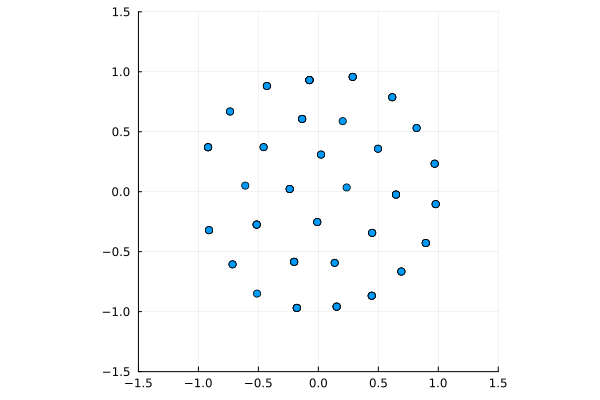

In [7]:
x = mini_batch(K)
x = encoder(x, peak_const)
p1 = Plots.scatter(x[1,:], x[2,:],legend=false, xlims=[-1.5,1.5], 
    ylims=[-1.5,1.5], aspect_ratio=1)

In [8]:
savefig("autoencoder-model.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_5/autoencoder-model.pdf"